# Import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import muon as mu
import os

/home/chayan/anaconda3/envs/umint/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pysam
import hdf5plugin

In [3]:
mu.set_options(display_style = "html", display_html_expand = 0b000)

# Load RNA data

In [4]:
# This is the directory where those files are downloaded to
data_dir = "/home/chayan/UMINT/pbmc10k/"

In [5]:
# Remove file prefixes if any
#prefix = "pbmc_granulocyte_sorted_10k_"
#for file in os.listdir(data_dir):
#    if file.startswith(prefix):
#        new_filename = file[len(prefix):]
#        os.rename(os.path.join(data_dir, file), os.path.join(data_dir, new_filename))

In [6]:
mdata = mu.read_10x_h5(os.path.join(data_dir, "filtered_feature_bc_matrix.h5"))
mdata.var_names_make_unique()
mdata

/home/chayan/anaconda3/envs/umint/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from /home/chayan/UMINT/pbmc10k/filtered_feature_bc_matrix.h5


/home/chayan/anaconda3/envs/umint/lib/python3.7/site-packages/mudata/_core/mudata.py:447: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  f"{attr}_names are not unique. To make them unique, call `.{attr}_names_make_unique`."


Added peak annotation from /home/chayan/UMINT/pbmc10k/atac_peak_annotation.tsv to .uns['atac']['peak_annotation']
Added gene names to peak annotation in .uns['atac']['peak_annotation']
Located fragments file: /home/chayan/UMINT/pbmc10k/atac_fragments.tsv.gz


[W::hts_idx_load2] The index file is older than the data file: /home/chayan/UMINT/pbmc10k/atac_fragments.tsv.gz.tbi


rna,bool,numpy.ndarray,
atac,bool,numpy.ndarray,
atac,collections.OrderedDict,1 element,peak_annotation: DataFrame (141066 x 3)
files,collections.OrderedDict,1 element,fragments: /home/chayan/UMINT/pbmc10k/atac_fragments.tsv.gz


# Preprocessing RNA

In [7]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 11909 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

QC

In [8]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

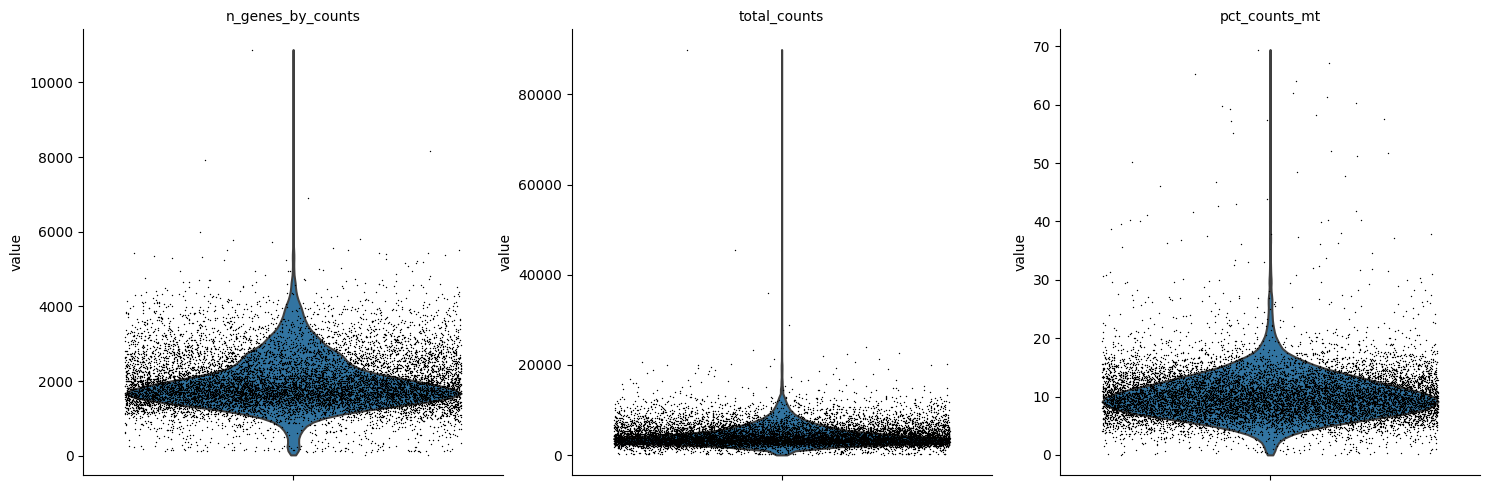

In [9]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Filter genes by expression values

In [10]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# This is analogous to
#   sc.pp.filter_genes(rna, min_cells=3)
# but does in-place filtering and avoids copying the object

Filter cells

In [11]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 5000))
# This is analogous to
#   sc.pp.filter_cells(rna, min_genes=200)
#   rna = rna[rna.obs.n_genes_by_counts < 5000, :]
# but does in-place filtering avoiding copying the object

mu.pp.filter_obs(rna, 'total_counts', lambda x: x < 15000)
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 20)

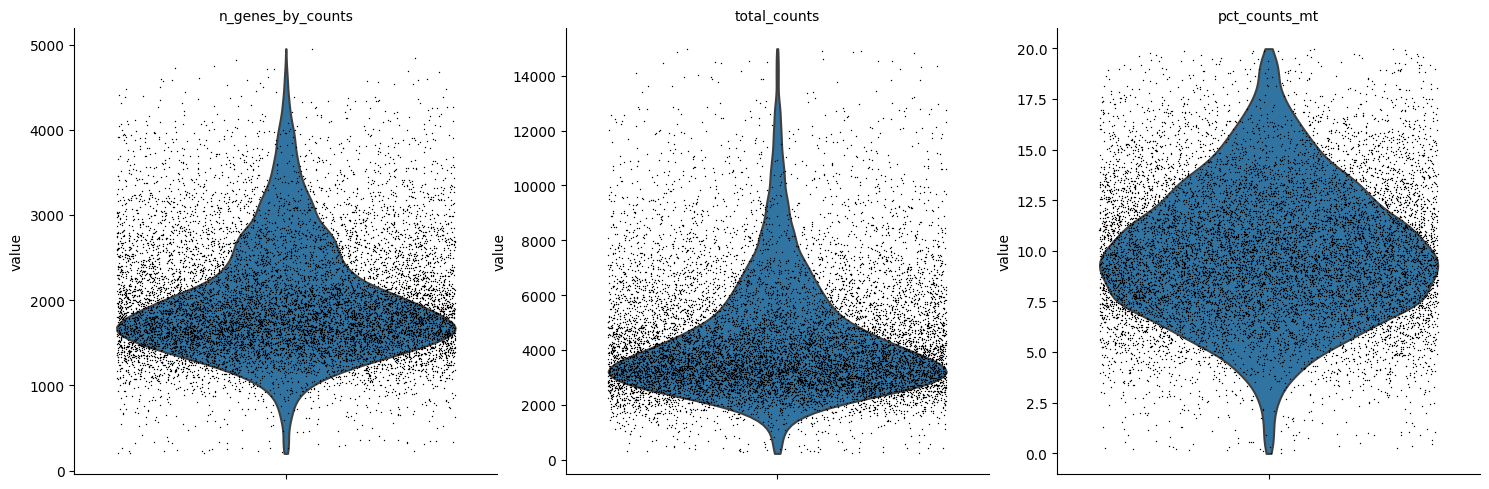

In [12]:
sc.pl.violin(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Normalization

In [13]:
sc.pp.normalize_total(rna, target_sum=1e4)

In [14]:
sc.pp.log1p(rna)

Feature Selection (HGV)

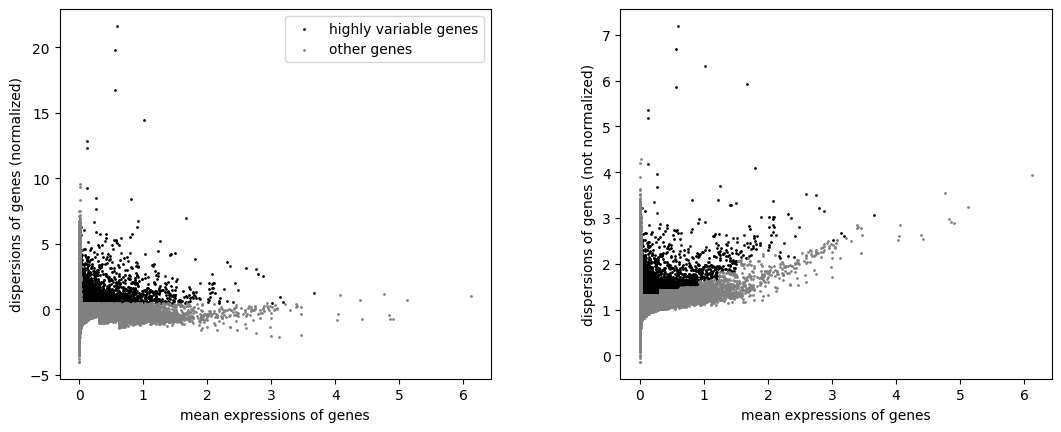

In [15]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(rna)

In [16]:
np.sum(rna.var.highly_variable)

3026

Scaling

In [17]:
rna.raw = rna #Saving log-normalised counts in .raw slot

In [18]:
sc.pp.scale(rna, max_value=10)

PCA and neighbourhood graph

In [19]:
sc.tl.pca(rna, svd_solver='arpack')

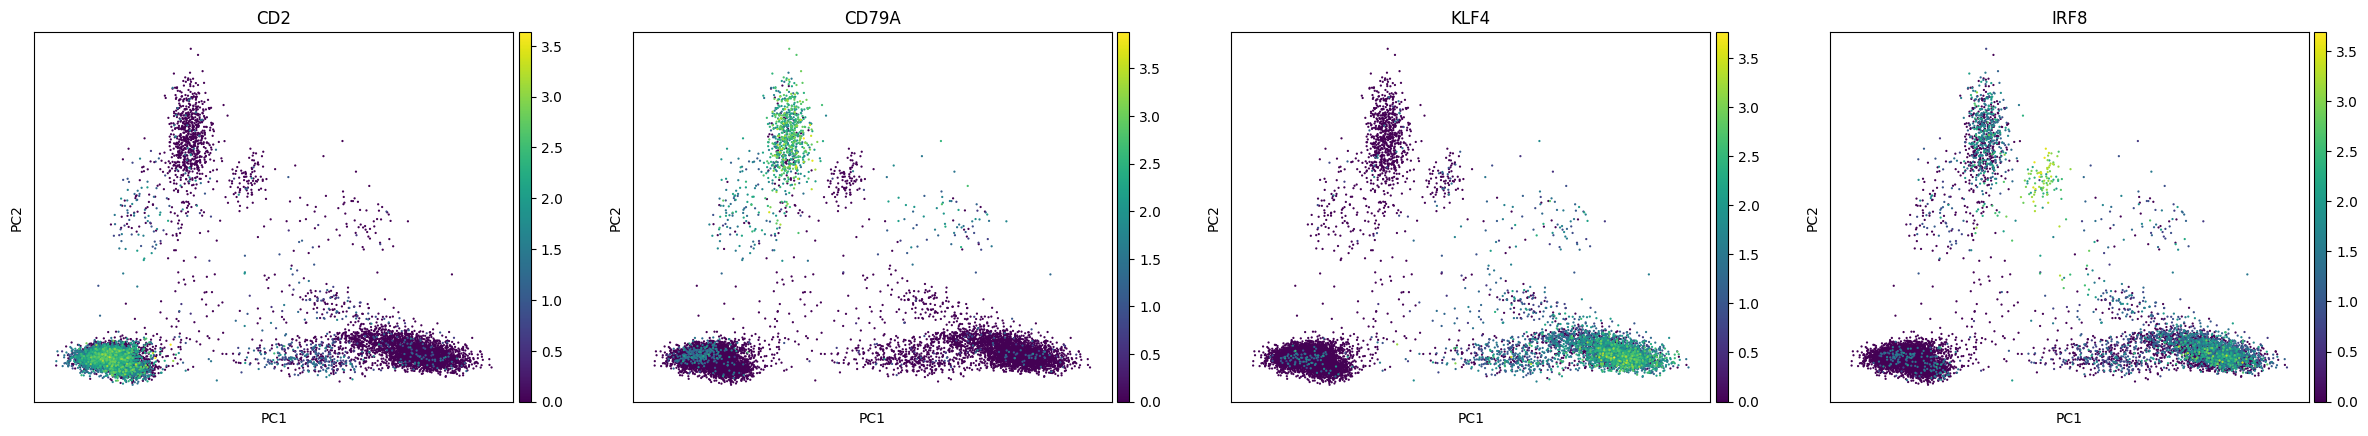

In [20]:
sc.pl.pca(rna, color=['CD2', 'CD79A', 'KLF4', 'IRF8'])

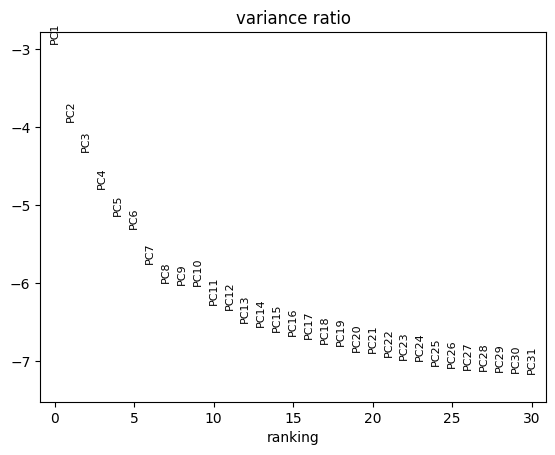

In [21]:
sc.pl.pca_variance_ratio(rna, log=True)

In [22]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

Clustering

In [23]:
sc.tl.leiden(rna, resolution=.5)

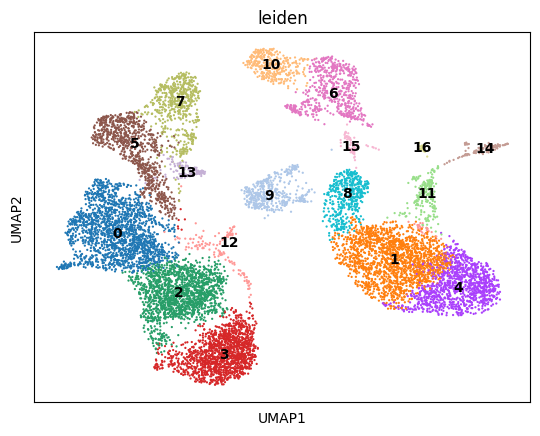

In [24]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)
sc.pl.umap(rna, color="leiden", legend_loc="on data")

Marker genes and Celltypes

In [25]:
sc.tl.rank_genes_groups(rna, 'leiden', method='t-test')

In [26]:
result = rna.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.set_option('display.max_columns', 50)
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p,14_n,14_p,15_n,15_p,16_n,16_p
0,INPP4B,0.000000e+00,SLC8A1,0.0,LEF1,0.000000e+00,LEF1,0.000000e+00,VCAN,0.0,CCL5,0.000000e+00,BANK1,0.000000e+00,GNLY,0.000000e+00,TCF7L2,0.000000e+00,NEAT1,4.718787e-212,IGHM,1.717806e-288,CD74,7.028884e-156,RPS29,5.846136e-17,SLC4A10,2.634788e-56,TCF4,2.131731e-108,BANK1,3.763633e-47,CDK6,1.042747e-13
1,IL32,0.000000e+00,PLXDC2,0.0,BCL11B,0.000000e+00,BACH2,0.000000e+00,PLXDC2,0.0,NKG7,1.645064e-259,CD74,0.000000e+00,NKG7,1.176725e-284,PSAP,0.000000e+00,PLXDC2,2.628610e-182,AFF3,7.544330e-270,CST3,2.806886e-113,RPS12,4.711174e-16,NKG7,5.384823e-49,RHEX,9.108036e-85,AFF3,3.540131e-43,MAML3,6.821403e-13
2,LTB,0.000000e+00,NEAT1,0.0,BACH2,0.000000e+00,PDE3B,0.000000e+00,DPYD,0.0,IL32,9.789418e-281,RALGPS2,2.564287e-316,CD247,8.015550e-287,LYN,0.000000e+00,ZEB2,7.727224e-167,BANK1,4.769347e-241,LYZ,3.950756e-117,RPS27,5.716096e-15,PHACTR2,5.413404e-47,IRF8,2.498881e-83,CD74,4.056818e-40,SOX4,1.456599e-12
3,SYNE2,0.000000e+00,DPYD,0.0,CAMK4,0.000000e+00,THEMIS,0.000000e+00,LRMDA,0.0,SYNE2,7.694852e-213,AFF3,1.996289e-313,PRF1,2.511484e-227,SAT1,0.000000e+00,LYST,6.523803e-153,CD74,1.556807e-232,HLA-DRA,1.114348e-112,RPS14,1.143721e-13,RORA,8.477108e-45,FCHSD2,1.102103e-83,MARCH1,3.041279e-38,NKAIN2,4.956515e-12
4,ANK3,0.000000e+00,AOAH,0.0,FHIT,0.000000e+00,NELL2,0.000000e+00,ARHGAP26,0.0,PRKCH,3.574277e-199,MS4A1,1.361494e-278,KLRD1,3.203746e-177,MTSS1,1.535678e-289,DPYD,1.410995e-156,FCRL1,6.639307e-170,HLA-DRB1,5.040392e-105,RPL13,2.993995e-13,SYNE2,8.133900e-43,UGCG,2.849758e-78,LYN,1.349819e-37,RPLP0,1.187223e-11
5,CDC14A,0.000000e+00,TYMP,0.0,MALAT1,0.000000e+00,BCL11B,0.000000e+00,NEAT1,0.0,GZMA,2.554380e-174,OSBPL10,8.911794e-228,GZMA,1.293044e-171,CST3,7.773710e-290,SLC8A1,1.506365e-141,RALGPS2,3.628682e-166,HDAC9,1.232631e-103,RPL30,8.805339e-12,IL7R,1.387635e-38,AFF3,3.814406e-81,HLA-DRA,1.141581e-35,RACK1,2.365494e-11
6,IL7R,0.000000e+00,JAK2,0.0,RPS27A,0.000000e+00,CAMK4,0.000000e+00,FCN1,0.0,SKAP1,2.412322e-182,HLA-DRA,6.100709e-255,SYNE1,7.231509e-166,WARS,1.901690e-280,TYMP,1.073279e-145,HLA-DRA,5.218864e-177,SAMHD1,1.721821e-107,RPL32,3.015812e-10,SKAP1,5.995929e-38,CD74,5.871105e-85,PLXDC2,9.282719e-33,RNF220,6.095781e-11
7,ITGB1,3.594589e-312,FCN1,0.0,TCF7,5.906382e-298,CD8B,4.348963e-319,CSF3R,0.0,A2M,2.369800e-162,CD79A,1.017956e-225,PRKCH,6.450980e-174,CTSS,6.795241e-305,LYN,1.311265e-143,BACH2,8.734891e-164,HLA-DPA1,2.756705e-94,RPS21,3.503708e-10,A2M,7.309596e-37,PLD4,6.527481e-73,MEF2C,5.807981e-31,ZNRF1,9.125703e-11
8,ARHGAP15,0.000000e+00,ZEB2,0.0,RPS27,6.938768e-307,OXNAD1,0.000000e+00,ZEB2,0.0,HLA-B,5.354894e-168,PAX5,4.409163e-221,CTSW,8.702646e-161,COTL1,2.684793e-274,FCN1,3.184471e-135,PAX5,3.466935e-149,HLA-DPB1,4.788035e-88,RPS26,1.133104e-09,CCL5,2.530043e-36,BCL11A,1.199667e-67,MS4A1,2.406745e-30,RPS3A,1.477149e-10
9,BCL11B,0.000000e+00,SAT1,0.0,INPP4B,5.022286e-282,TXK,3.266809e-311,RBM47,0.0,SYNE1,1.926444e-159,BLK,1.280629e-195,MCTP2,7.675640e-155,TYMP,1.570275e-287,AOAH,1.301608e-141,MS4A1,3.121565e-133,HLA-DQA1,3.627879e-87,RPL27A,5.494638e-09,KLRB1,6.298874e-36,RABGAP1L,1.325867e-70,PRKCB,5.573922e-30,EEF2,3.706141e-10


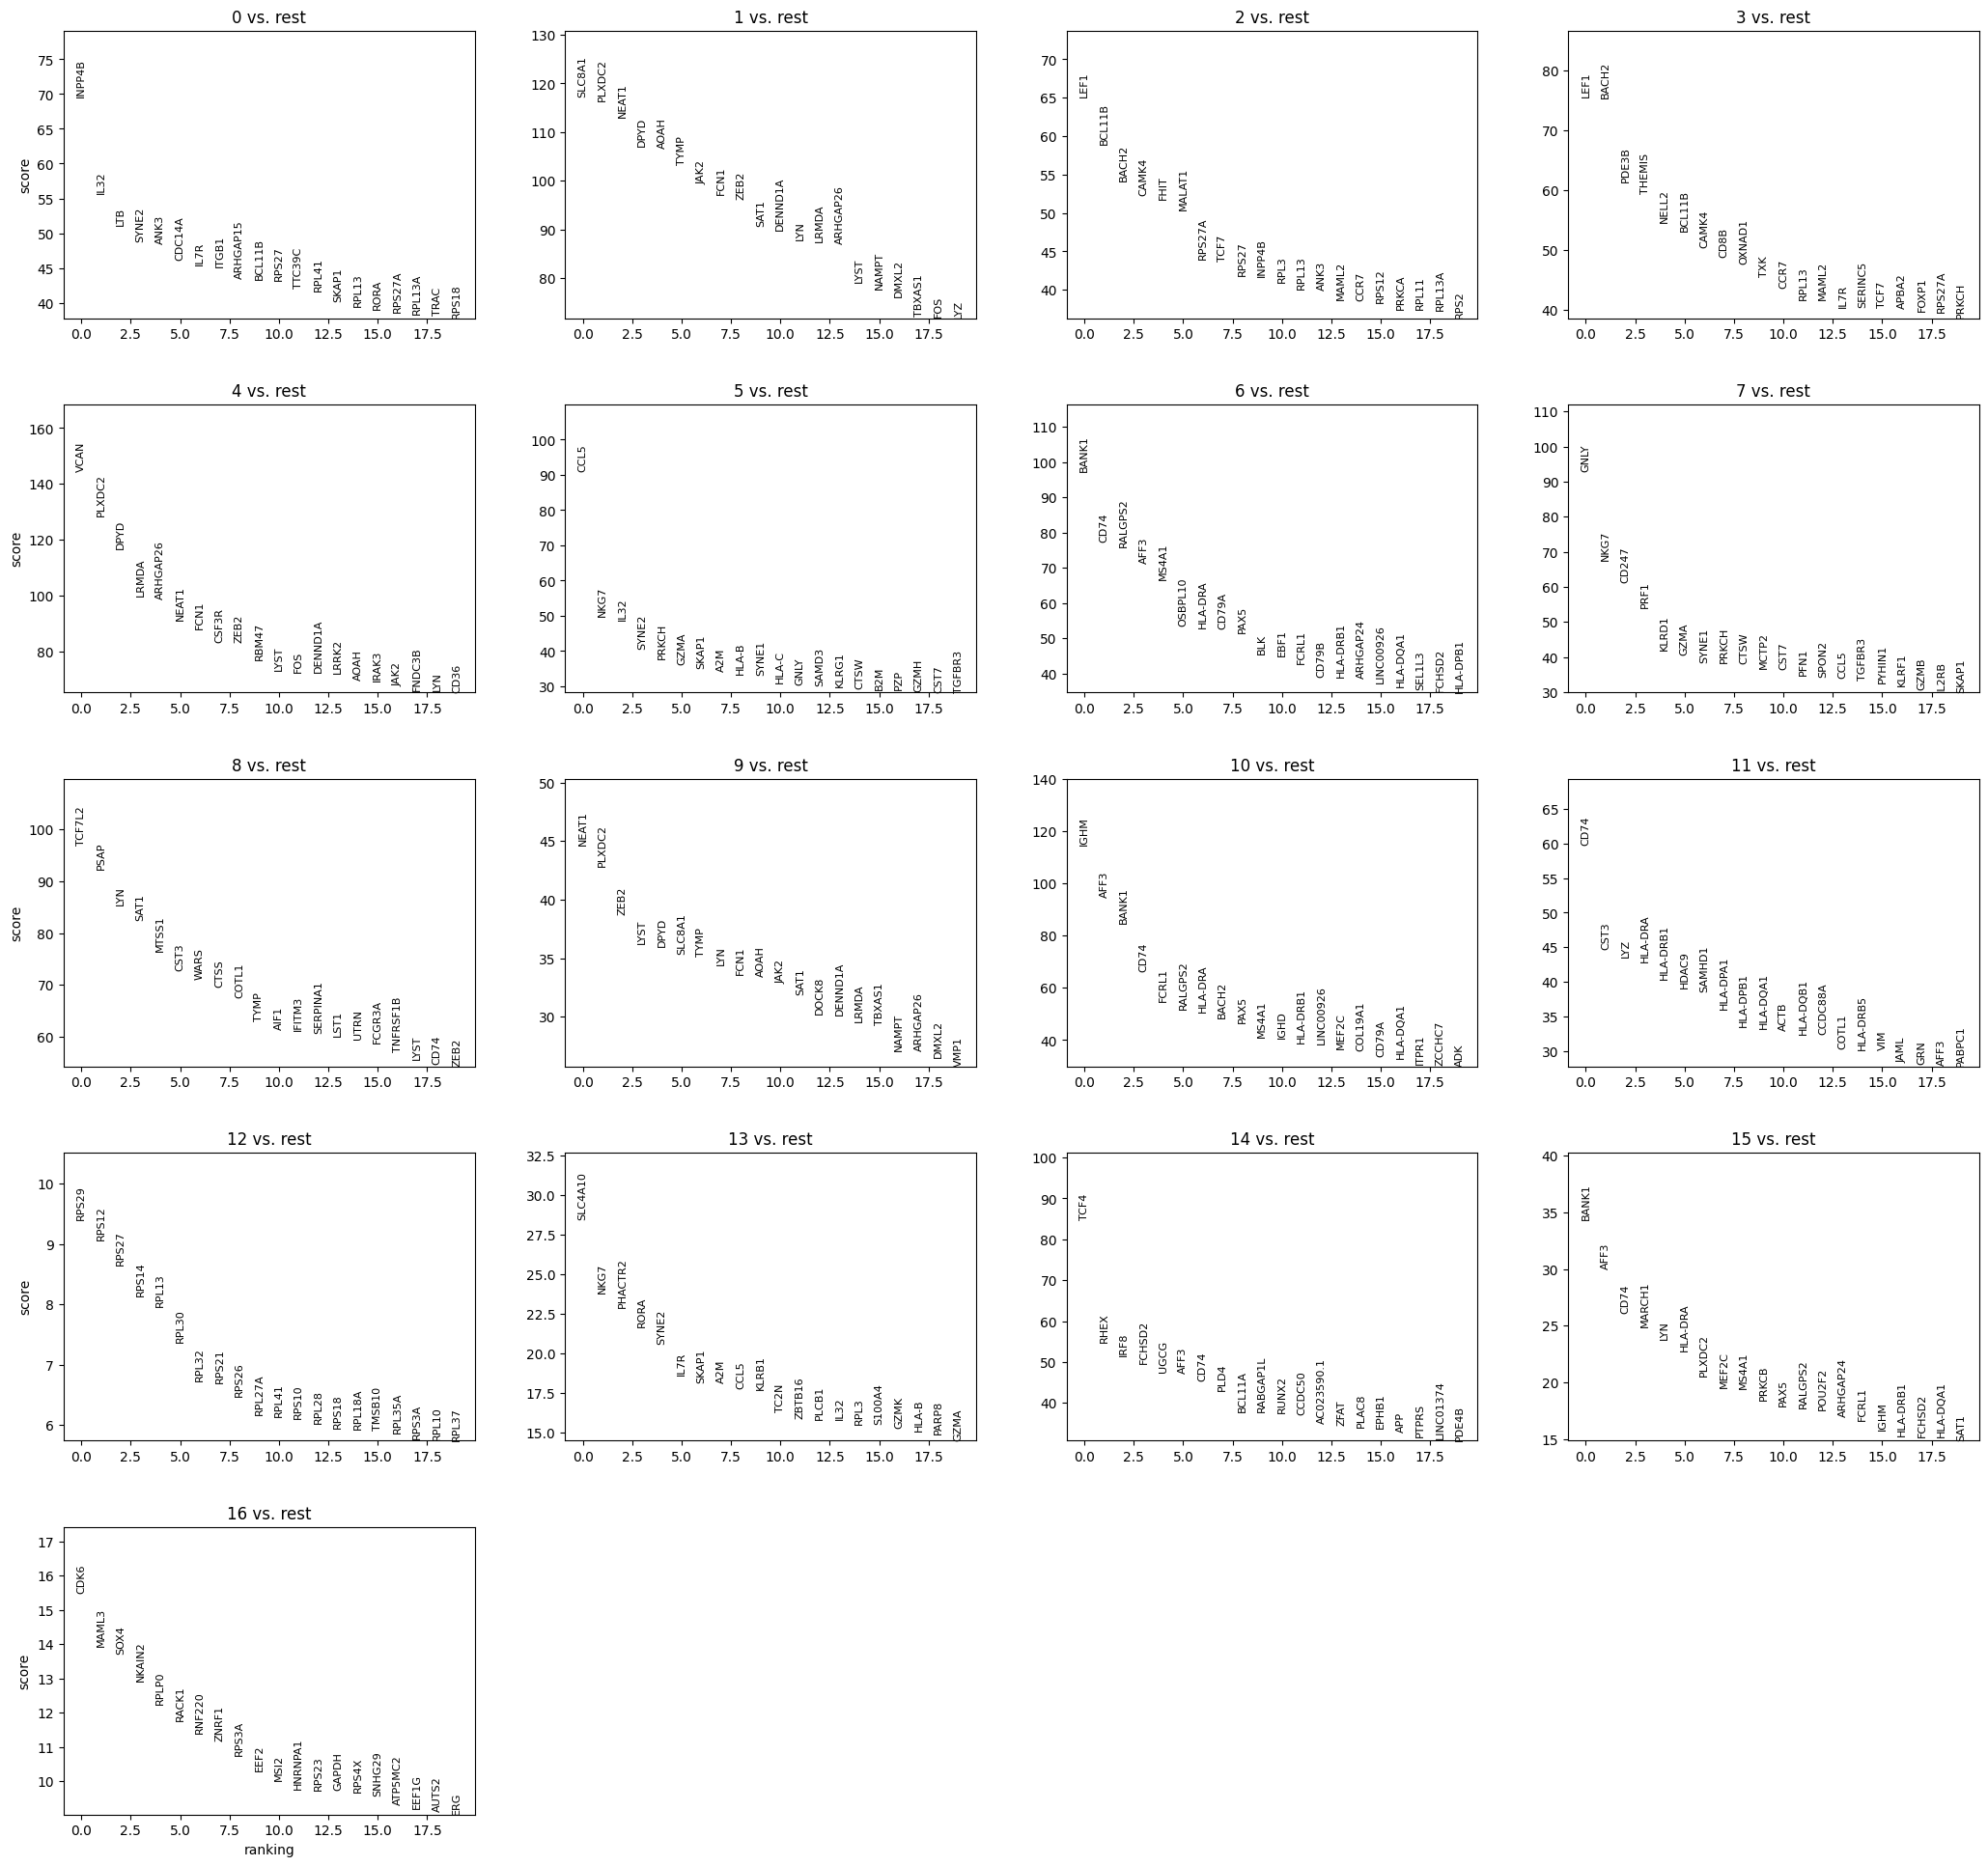

In [27]:
sc.pl.rank_genes_groups(rna, n_genes=20, sharey=False)

Exploring the data we notice clusters 9 and 15 seem to be composed of cells bearing markers for different cell lineages so likely to be noise (e.g. doublets). Cluster 12 has higher ribosomal gene expression when compared to other clusters. Cluster 16 seem to consist of proliferating cells.

We will remove cells from these clusters before assigning cell types names to clusters.

we got the clusters like the tutorial. Clusters 1 and 2 got interchanged

In [28]:
mu.pp.filter_obs(rna, "leiden", lambda x: ~x.isin(["9", "15", "12", "16"]))

In [29]:
new_cluster_names = {
    "0": "CD4+ memory T", "2": "CD8+ naïve T", "3": "CD4+ naïve T",
    "5": "CD8+ activated T", "7": "NK", "13": "MAIT",
    "6": "memory B", "10": "naïve B",
    "4": "CD14 mono", "1": "intermediate mono", "8": "CD16 mono",
    "11": "mDC", "14": "pDC",
}

rna.obs['celltype'] = rna.obs.leiden.astype("str").values
rna.obs.celltype = rna.obs.celltype.astype("category")
rna.obs.celltype = rna.obs.celltype.cat.rename_categories(new_cluster_names)

In [30]:
rna.obs.celltype.cat.reorder_categories([
    'CD4+ naïve T', 'CD4+ memory T', 'MAIT',
    'CD8+ naïve T', 'CD8+ activated T', 'NK',
    'naïve B', 'memory B',
    'CD14 mono', 'intermediate mono', 'CD16 mono',
    'mDC', 'pDC'], inplace=True)

/home/chayan/anaconda3/envs/umint/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  


In [31]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(rna.obs.celltype.cat.categories)))

rna.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

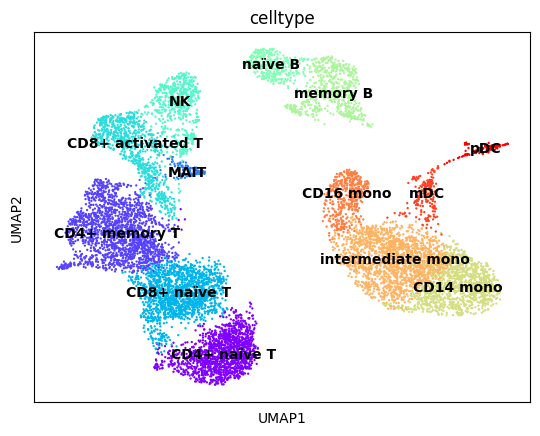

In [32]:
sc.pl.umap(rna, color="celltype", legend_loc="on data")

Marker genes

In [33]:
marker_genes = ['IL7R', 'TRAC',
                'ITGB1', # CD29
                'SLC4A10',
                'CD8A', 'CD8B', 'CCL5',
                'GNLY', 'NKG7',
                'CD79A', 'MS4A1', 'IGHM', 'IGHD',
                'IL4R', 'TCL1A',
                'KLF4', 'LYZ', 'S100A8', 'ITGAM', # CD11b
                'CD14', 'FCGR3A', 'MS4A7',
                'CST3', 'CLEC10A', 'IRF8', 'TCF4']

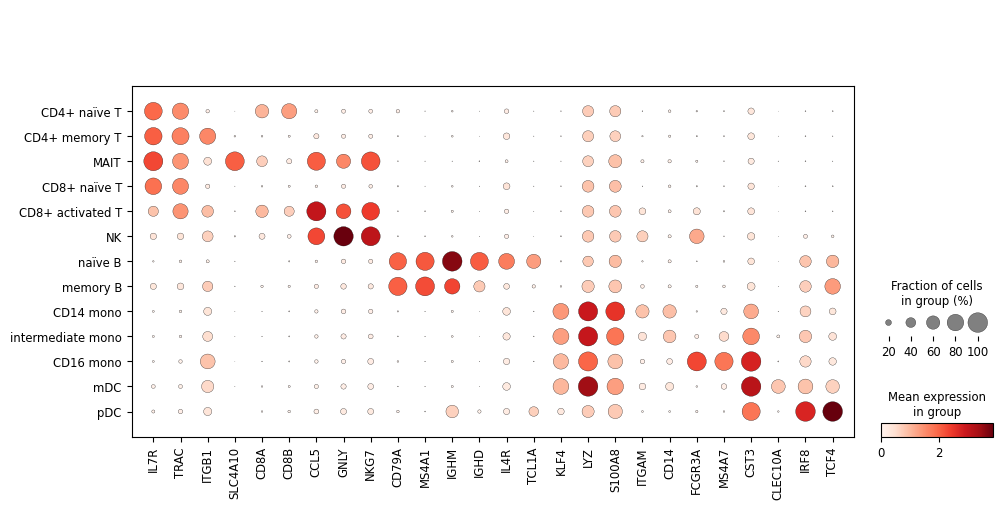

In [34]:
sc.pl.dotplot(rna, marker_genes, groupby='celltype');

# Saving multimodal data on disk

In [35]:
mdata.mod["atac"].uns = dict(mdata.mod["atac"].uns) 
mdata.mod["atac"].uns['files'] = dict(mdata.mod["atac"].uns['files'])
mdata.mod['atac'].uns['atac'] = dict(mdata.mod['atac'].uns['atac']) 

In [36]:
mdata.write("/home/chayan/UMINT/pbmc10k/pbmc10k.h5mu")

# Rough

rna.write_h5ad("/home/chayan/UMINT/pbmc10k/pbmc10k_rna.h5ad")

rna1 = sc.read_h5ad("/home/chayan/UMINT/pbmc10k/pbmc10k_rna.h5ad")

rna1